In [ ]:
https://github.com/ipab-rad/ilqr_pendulum

In [1]:
import gym
from autograd import grad, jacobian
import autograd.numpy as np
import copy
from matplotlib import pyplot as plt
from IPython import display

In [2]:
import torch
# import numpy as np
import gym
from PIL import Image
from torchvision.transforms import ToTensor
from e2c_model import *

w, h = int(48*2), 48
device = torch.device('cuda')
env_name = 'pendulum'
settings = {'planar': (1600, 2, 2), 'pendulum': (4608, 3, 1)}
obs_dim, z_dim, u_dim = settings[env_name]
model = E2C(obs_dim=obs_dim, z_dim=z_dim, u_dim=u_dim, env=env_name).to(device)
model.load_state_dict(torch.load('./model/model_1000.pth'))
model.eval()

E2C(
  (encoder): PendulumEncoder(
    (net): Sequential(
      (0): Linear(in_features=4608, out_features=800, bias=True)
      (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=800, out_features=800, bias=True)
      (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=800, out_features=6, bias=True)
    )
  )
  (decoder): PendulumDecoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=800, bias=True)
      (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=800, out_features=800, bias=True)
      (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=800, out_features=4608, bias=True)
      (7): Sigmoid()
    )
  )
  (trans): PendulumTransit

## Finding goal_state(theta, theta_dot) = (0, 0) (i.e. swing up) in latent space

In [3]:
def rgb2bw(arr):
    width = int(48 * 2)
    height = 48
    img = Image.fromarray(arr)
    img_bw = img.convert('L').resize((int(width/2),height)).point(lambda x: 0 if x < 128 else 255, '1')
    
    return img_bw

env = gym.make('Pendulum-v1')
env = env.unwrapped
env.reset()

goal_state = np.array([0, 0])
env.state = goal_state

goal_img = rgb2bw(env.render(mode='rgb_array'))
goal_img = Image.fromarray(np.hstack((goal_img, goal_img)))
goal_img = ToTensor()((goal_img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
goal_x = goal_img.view(-1, model.obs_dim).double().to(device)

mu, logvar = model.encode(goal_x)
goal_z = mu.cpu().detach().numpy()[0]
print('goal_z = ',goal_z)    #goal_z.shape = torch.Size([1, 3])

env.close()

C:\Users\kihong\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


goal_z =  [ 2.07999733 -1.14590523 -0.94871215]


In [4]:
# practice
z_np = goal_z
print('z in np = ', z_np)
z_torch = torch.FloatTensor(z_np).double().unsqueeze(0).to(model.device)
print('z in torch = ', z_torch)
x = model.decode(z_torch)
print('reconstructed x = ', x)

u_temp = np.array([0])
u_temp = torch.FloatTensor(u_temp).double().unsqueeze(0).to(model.device)
z_temp, A, B = model.trans.plan(z_torch, u_temp)
print('A = \n', A.cpu().detach().numpy()[0])
print('B = \n', B.cpu().detach().numpy()[0])

z in np =  [ 2.07999733 -1.14590523 -0.94871215]
z in torch =  tensor([[ 2.0800, -1.1459, -0.9487]], device='cuda:0')
reconstructed x =  tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
A = 
 [[1.09829001 0.06811577 0.11700445]
 [0.61050903 1.42308765 0.72675007]
 [0.03062456 0.02122307 1.03645549]]
B = 
 [[-0.02517377]
 [-0.00726502]
 [-0.00325617]]


In [23]:
class ILqr:
    
    def __init__(self, dynamics, running_cost, final_cost, state_dim, horizon=10):
        
        self.f = dynamics
        self.horizon = horizon
        
        self.f_x = jacobian(self.f,0)
        self.f_u = jacobian(self.f,1)
        
        self.f_xx = jacobian(self.f_x,0)
        self.f_uu = jacobian(self.f_u,1)
        self.f_ux = jacobian(self.f_u,0)
        
        self.lf = final_cost
        self.lf_x = grad(self.lf,0)
        self.lf_xx = jacobian(self.lf_x,0)
        
        self.v = [0.0 for _ in range(horizon+1)]
        self.v_x = [np.zeros(state_dim) for _ in range(horizon+1)]
        self.v_xx = [np.zeros((state_dim,state_dim)) for _ in range(horizon+1)]
        
        self.l = running_cost
        self.l_x = grad(self.l,0)
        self.l_u = grad(self.l,1)
        
        self.l_xx = jacobian(self.l_x,0)
        self.l_uu = jacobian(self.l_u,1)
        self.l_ux = jacobian(self.l_u,0)
        
    def jacob(self, z, u):
        z = torch.FloatTensor(z).double().unsqueeze(0).to(model.device)
        u = torch.FloatTensor(u).double().unsqueeze(0).to(model.device)
        z_next, A_t, B_t = model.trans.plan(z, u)
        
        A_t = A_t.cpu().detach().numpy()[0]
        B_t = B_t.cpu().detach().numpy()[0]
        
        return A_t, B_t
        
    def backward(self, x_seq, u_seq):
        
        self.v[-1] = self.lf(x_seq[-1],u_seq[-1])
        self.v_x[-1] = self.lf_x(x_seq[-1],u_seq[-1])
        self.v_xx[-1] = self.lf_xx(x_seq[-1],u_seq[-1])
        
        k_seq = []
        kk_seq = []
        
        for t in range(self.horizon-1,-1,-1):
            
            x = x_seq[t]
            u = u_seq[t]
            
            # Evaluate expansion coeeficients
            f_x_t, f_u_t = self.jacob(x, u)
            #f_x_t = self.f_x(x,u)
            #f_u_t = self.f_u(x,u)
            
            f_xx_t = 0 #self.f_xx(x,u)
            f_uu_t = 0 #self.f_uu(x,u)
            f_ux_t = 0 #self.f_ux(x,u)
            
            l_x_t = self.l_x(x,u)
            l_u_t = self.l_u(x,u)
            
            l_xx_t = self.l_xx(x,u)
            l_uu_t = self.l_uu(x,u)
            l_ux_t = self.l_ux(x,u)
            
            v_x_t = self.v_x[t+1]
            v_xx_t = self.v_xx[t+1]
            
            q_x = l_x_t + np.matmul(f_x_t.T,v_x_t)
            q_u = l_u_t + np.matmul(f_u_t.T,v_x_t)
            
            q_xx = l_xx_t + np.matmul(np.matmul(f_x_t.T,v_xx_t),f_x_t) + (v_x_t.reshape(-1,1,1)*f_xx_t).sum(axis=0)
            
            q_uu = l_uu_t + np.matmul(np.matmul(f_u_t.T,v_xx_t),f_u_t) + (v_x_t.reshape(-1,1,1)*f_uu_t).sum(axis=0)
            
            q_ux = l_ux_t + ((f_u_t.T).dot(v_xx_t)).dot(f_x_t) + (v_x_t.reshape(-1,1,1)*f_ux_t).sum(axis=0)
        
            # Invert with some regularisation
            q_uu_inv = np.linalg.inv(q_uu.reshape(1,1)+1e-9*np.eye(q_uu.shape[0]))
            
            k = -q_uu_inv.dot(q_u) # open loop gain
            kk = -q_uu_inv.dot(q_ux) # feedback gain
            
            
            self.v[t] += 0.5*(k.T.dot(q_uu)).dot(k) + k.T.dot(q_u)#q_u.dot(k)
            self.v_x[t] = q_x + (kk.T.dot(q_uu)).dot(k) + kk.T.dot(q_u) + q_ux.T.dot(k)#q_u.dot(kk)
            self.v_xx[t] = q_xx + (kk.T.dot(q_uu)).dot(kk) + kk.T.dot(q_ux) + q_ux.T.dot(kk)#q_ux.T.dot(kk)
            
            k_seq.append(k)
            kk_seq.append(kk)
        
        k_seq.reverse()
        kk_seq.reverse()
        
        return k_seq,kk_seq
    
    def forward(self, x_seq, u_seq, k_seq, kk_seq,alpha):
        
        x_seq_hat = np.array(x_seq)
        u_seq_hat = np.array(u_seq)
        
        for t in range(len(u_seq)):
            control = alpha**t*k_seq[t] + np.matmul(kk_seq[t], (x_seq_hat[t] - x_seq[t]))
            u_seq_hat[t] = np.clip(u_seq[t] + control,-2,2)
            x_seq_hat[t+1] = self.f(x_seq_hat[t], u_seq_hat[t])
            
        return x_seq_hat, u_seq_hat
    
    
def cost(x,u):
    # R_z = I_3, R_u = 0.1 * I_1
    # goal_z = [ 2.0800, -1.1459, -0.9487] for model = model_1000.pth
    costs = 10*((x[0] - goal_z[0])**2 + (x[1] - goal_z[1])**2 + (x[2] - goal_z[2])**2) + 0.1*(u**2)
    
    return costs


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)


def latent_dyn(z,u):
    """
    param x: latent variable z (type = np.array)
    param u: input torque (type = np.array)
    
    input.type = np.array 
    middle.type = tensor
    output.type = np.array
    """
    # change type from numpy to torch.tensor
    z = torch.FloatTensor(z).double().unsqueeze(0).to(model.device)
    u = torch.FloatTensor(u).double().unsqueeze(0).to(model.device)
    
    z_next, A, B = model.trans.plan(z, u)
    #z_next = z_next.cpu().detach().numpy()[0]
    
    A = A.cpu().detach().numpy()[0]
    B = B.cpu().detach().numpy()[0]
    z_next = z_next.cpu().detach().numpy()[0]
    u = u.cpu().detach().numpy()[0]
    z_next = np.matmul(A, z_next) + np.matmul(B, u) 
    
    return z_next

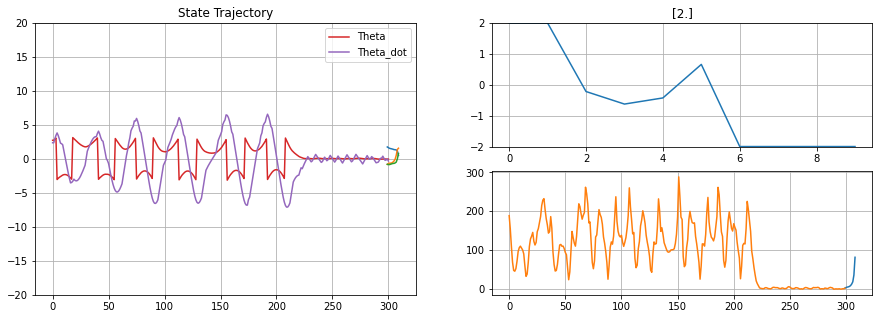

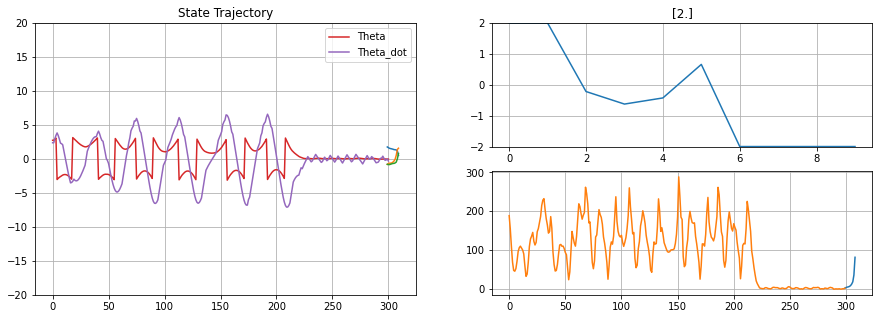

In [30]:
#ILqr(dynamics, running cost, final cost, state_dim, horizon)
ilqr = ILqr(lambda x, u: latent_dyn(x, u), lambda x, u: cost(x,u), lambda x, u: cost(x,u), 3, horizon=10)

env = gym.make("Pendulum-v1")
env = env.unwrapped
env.reset()

# Assume start high enough to stabilise
u_seq = [np.random.uniform(-2, 2, 1) for _ in range(ilqr.horizon)]
c_seq = []    # cost sequence

initial_state = np.array([np.pi/6*5, 2])
env.state = initial_state

# processing initial image(=initial x)
prev_img = rgb2bw(env.render(mode='rgb_array'))
state, reward, done, info = env.step([0])
cur_img = rgb2bw(env.render(mode='rgb_array'))
start_img = Image.fromarray(np.hstack((prev_img, cur_img)))
start_img = ToTensor()((start_img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
start_img = start_img.view(-1, model.obs_dim).double().to(device)

mu, logvar = model.encode(start_img)
z = mu.cpu().detach().numpy()[0]

st_seq = []    # real state (theta, theta_dot) in pendulum env
th = np.arctan2(state[1],state[0])
st_seq.append(np.array((th,state[2])))

plt.figure(figsize=(15,5))
for j in range(300):
    
    z_seq = [z]
    c_seq.append(cost(z_seq[0],u_seq[0]))
    
    for t in range(ilqr.horizon):
        z_seq.append(latent_dyn(z_seq[-1], u_seq[t]))

    for rep in range(20):
        k_seq, kk_seq = ilqr.backward(z_seq, u_seq)
        z_seq, u_seq = ilqr.forward(z_seq, u_seq, k_seq, kk_seq, alpha=0.99)
    
    st_seq.append(np.array((th,state[2])))
    
    env.render()
    state,_,_,_ = env.step(u_seq[0])
    
    th = np.arctan2(state[1], state[0])
    
    prev_img = copy.deepcopy(cur_img)
    cur_img = rgb2bw(env.render(mode='rgb_array'))
    img = Image.fromarray(np.hstack((prev_img, cur_img)))
    img = ToTensor()((img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
    img = img.view(-1, model.obs_dim).double().to(device)
    
    mu, logvar = model.encode(img)
    z = mu.cpu().detach().numpy()[0]
    
    plt.cla()
    plt.subplot(1,2,1)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon+1),z_seq)
    plt.plot(np.array(st_seq)[:,0], label='Theta')
    plt.plot(np.array(st_seq)[:,1], label='Theta_dot')
    plt.ylim(-20,20)
    plt.grid()
    plt.title('State Trajectory')
    plt.legend()

    plt.subplot(2,2,2)
    plt.cla()
    plt.plot(u_seq)
    plt.title(u_seq[0])
    plt.ylim(-2,2)
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon),[cost(z_seq[t],u_seq[t]) for t in range(len(u_seq))])
    plt.plot(c_seq)
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())
        
env.close()
